# LQR法でヒューマノイドのレギュレーションのチュートリアル

In [1]:
import mujoco
mujoco.MjModel.from_xml_string('<mujoco/>')
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg

# Graphics and plotting.
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [2]:
with open('mujoco/model/humanoid/humanoid.xml', 'r') as f:
  xml = f.read()

In [3]:
# print(xml)

In [4]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)


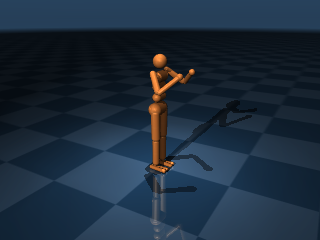

In [5]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())


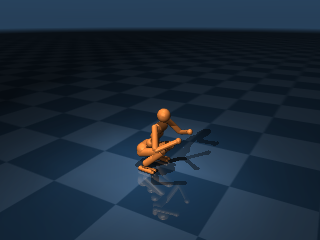


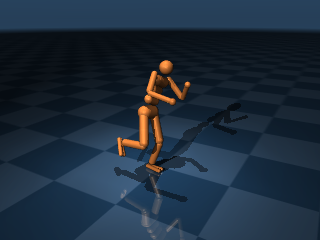


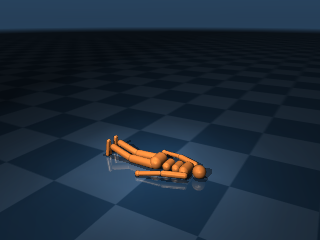


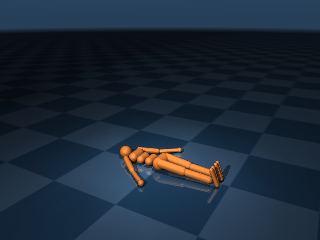

In [6]:
## keyframeに保存された姿勢を表示
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [7]:
#中腰から自由落下
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Initialize to the standing-on-one-leg pose.
mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data)
    pixels = renderer.render()
    frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

In [8]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Make a new camera, move it to a closer distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2

mujoco.mj_resetDataKeyframe(model, data, 1)

frames = []
while data.time < DURATION:
  # Set control vector.
  data.ctrl = np.random.randn(model.nu)#乱数で全軸に適当な速度指令を与える

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('torso').subtree_com #特定のbodyをカメラに追尾させる

    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

## 順動力学と逆動力学計算
- 力与えて加速度算出する
    - `mj_forward`
- 加速度与えて力算出
    - `mj_inverse`

In [9]:
mujoco.mj_resetDataKeyframe(model, data, 1) #中腰姿勢に初期化
mujoco.mj_forward(model, data) 
data.qacc = 0  # Assert that there is no the acceleration.
mujoco.mj_inverse(model, data)
print(data.qfrc_inverse) #加速度を発生させない全軸の力

[  0.      0.    275.879 -33.186   4.995  -6.688  -4.305   3.693 -15.451 -10.906   0.412  -1.613
  -9.793  -2.312  -0.366  -5.913  -0.417  -1.914   5.759   2.665  -0.202  -5.755   0.994   1.141
  -1.987   3.821   1.151]


In [10]:
joint_names = [model.joint(i).name for i in range(model.njnt)]
all_dof = 0
joint_types = ["free", "ball", "slide", "hinge"]
for jn in joint_names:
    n_pos = len(data.joint(jn).qacc)
    j_type = model.joint(jn).type[0]
    print(jn,":",n_pos, "-DoF, type:", joint_types[j_type])
    all_dof += n_pos
print("all-DoF is", all_dof)

root : 6 -DoF, type: free
abdomen_z : 1 -DoF, type: hinge
abdomen_y : 1 -DoF, type: hinge
abdomen_x : 1 -DoF, type: hinge
hip_x_right : 1 -DoF, type: hinge
hip_z_right : 1 -DoF, type: hinge
hip_y_right : 1 -DoF, type: hinge
knee_right : 1 -DoF, type: hinge
ankle_y_right : 1 -DoF, type: hinge
ankle_x_right : 1 -DoF, type: hinge
hip_x_left : 1 -DoF, type: hinge
hip_z_left : 1 -DoF, type: hinge
hip_y_left : 1 -DoF, type: hinge
knee_left : 1 -DoF, type: hinge
ankle_y_left : 1 -DoF, type: hinge
ankle_x_left : 1 -DoF, type: hinge
shoulder1_right : 1 -DoF, type: hinge
shoulder2_right : 1 -DoF, type: hinge
elbow_right : 1 -DoF, type: hinge
shoulder1_left : 1 -DoF, type: hinge
shoulder2_left : 1 -DoF, type: hinge
elbow_left : 1 -DoF, type: hinge
all-DoF is 27


- フローティングベースの先から回転関節が連なっている

In [11]:
print(data.qfrc_inverse[2])

275.87856563199045


この値がでかいということは、倒れない（動かない）ためにフローティングベースにZ軸方向にでかい力が必要ということ

Zの位置を、床にちょっとめり込んだとこから、1マイクロメートルずつずらしていったらこの値は？↓

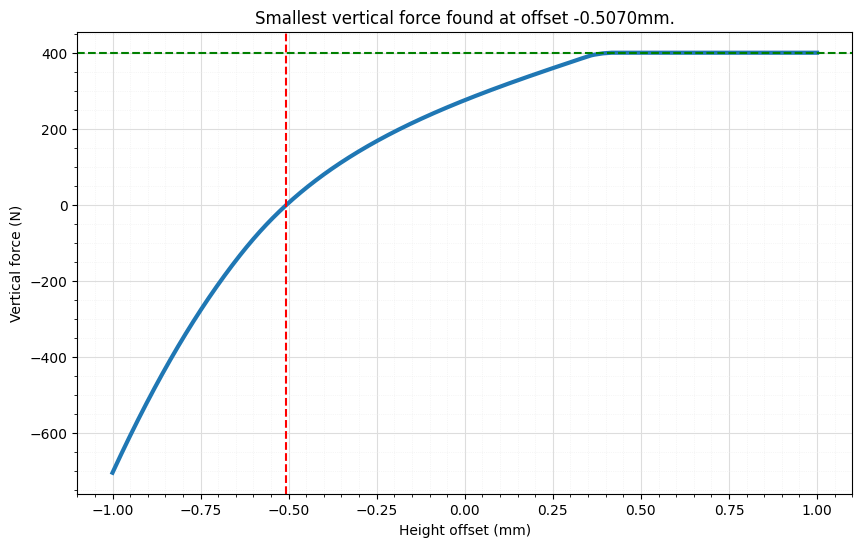

In [12]:
height_offsets = np.linspace(-0.001, 0.001, 2001)
vertical_forces = []
for offset in height_offsets:
  mujoco.mj_resetDataKeyframe(model, data, 1)
  mujoco.mj_forward(model, data)
  data.qacc = 0
  # Offset the height by `offset`.
  data.qpos[2] += offset
  mujoco.mj_inverse(model, data)
  vertical_forces.append(data.qfrc_inverse[2])

# Find the height-offset at which the vertical force is smallest.
idx = np.argmin(np.abs(vertical_forces))
best_offset = height_offsets[idx]

# Plot the relationship.
plt.figure(figsize=(10, 6))
plt.plot(height_offsets * 1000, vertical_forces, linewidth=3)
# Red vertical line at offset corresponding to smallest vertical force.
plt.axvline(x=best_offset*1000, color='red', linestyle='--')
# Green horizontal line at the humanoid's weight.
weight = model.body_subtreemass[1]*np.linalg.norm(model.opt.gravity)
plt.axhline(y=weight, color='green', linestyle='--')
plt.xlabel('Height offset (mm)')
plt.ylabel('Vertical force (N)')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.title(f'Smallest vertical force '
          f'found at offset {best_offset*1000:.4f}mm.')
plt.show()

- 床に深めにめり込んでいるときは、反発して帰ってくるのを抑えるZにマイナス方向の力が必要
- 逆に床から浮き出すと、ロボにかかる重力と等しい400Nに収束する
- この力が0に近くなる-0.5付近ではつまり、余計な力なしで、止まっていれる（床が支えてくれる）
    - **0じゃないんだ！**

In [13]:
mujoco.mj_resetDataKeyframe(model, data, 1)
mujoco.mj_forward(model, data)
data.qacc = 0
data.qpos[2] += best_offset
qpos0 = data.qpos.copy()  # Save the position setpoint.
mujoco.mj_inverse(model, data)
qfrc0 = data.qfrc_inverse.copy()
print('desired forces:', qfrc0)

desired forces: [  0.      0.     -0.191  -3.447   0.222  -0.817   2.586  14.637 -18.64  -10.906   0.412  -1.613
  -9.793  -2.312  -0.366 -23.755  -2.171  12.264  26.101  13.337  -0.113  -5.755   0.994   1.141
  -1.987   3.821   1.151]


In [14]:
print(data.actuator_moment.shape)
np.atleast_2d(qfrc0).shape
# np.linalg.pinv(data.actuator_moment).shape

(21, 27)


(1, 27)

In [15]:
# data.actuator_momentはモーメントモーメントアーム行列＝ヤコビアンだと思うが、
# 右からかけてるとことかよくわからん
ctrl0 = np.atleast_2d(qfrc0) @ np.linalg.pinv(data.actuator_moment)
ctrl0 = ctrl0.flatten()  # Save the ctrl setpoint.
print('control setpoint:', ctrl0)

control setpoint: [ 0.065  0.366 -0.466 -0.273  0.01  -0.013 -0.122 -0.116 -0.018 -0.594 -0.054  0.102  0.326  0.667
 -0.006 -0.288  0.05   0.029 -0.099  0.191  0.029]


In [16]:
#多分、仮想仕事の原理的に静力学を使って、姿勢を保つ入力を求めている
data.ctrl = ctrl0
mujoco.mj_forward(model, data)
print('actuator forces:', data.qfrc_actuator)

actuator forces: [  0.      0.      0.      0.      0.      0.      2.586  14.637 -18.64  -10.906   0.412  -1.613
  -9.793  -2.312  -0.366 -23.755  -2.171  12.264  26.101  13.337  -0.113  -5.755   0.994   1.141
  -1.987   3.821   1.151]


In [17]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Set the state and controls to their setpoints.
mujoco.mj_resetData(model, data)
data.qpos = qpos0
data.ctrl = ctrl0

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    # Set the lookat point to the humanoid's center of mass.
    camera.lookat = data.body('torso').subtree_com
    renderer.update_scene(data, camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

### LQRの重み設計

In [18]:
nu = model.nu  # 制御入力次元 free joint以外の回転関節21次元
R = np.eye(nu) #Rは単位行列にしてQを設計する

In [19]:
print([model.body(i).name for i in range(model.nbody)])

['world', 'torso', 'head', 'waist_lower', 'pelvis', 'thigh_right', 'shin_right', 'foot_right', 'thigh_left', 'shin_left', 'foot_left', 'upper_arm_right', 'lower_arm_right', 'hand_right', 'upper_arm_left', 'lower_arm_left', 'hand_left']


重心（CoM）を足の上に保つためのバランス・コストを計算

In [20]:
nv = model.nv  # Shortcut for the number of DoFs.

# 重心ヤコビアンを取得
# https://mujoco.readthedocs.io/en/stable/APIreference/APIfunctions.html#mj-jac
mujoco.mj_resetData(model, data) #一回リセット
data.qpos = qpos0 # qpos0は上のセルで、中腰にして設置の高さをベストに調節したやつ
mujoco.mj_forward(model, data) #動力学計算するときはこれ呼ぶのを忘れない
jac_com = np.zeros((3, nv)) #解用の箱
mujoco.mj_jacSubtreeCom(model, data, jac_com, model.body('torso').id)
# mj_jacSubtreeComでは指定したbodyをルートとするサブツリーの重心へのヤコビアンを計算する
# ここではtorsoから四肢が伸びていて、体全体の重心と思って良さそう

# left footの重心へのヤコビアン
jac_foot = np.zeros((3, nv))
mujoco.mj_jacBodyCom(model, data, jac_foot, None, model.body('foot_left').id)
# mj_jacBodyComは指定したbodyの重心へのヤコビアンを計算する
# ここでNoneにしてる所は姿勢成分のヤコビアン

jac_diff = jac_com - jac_foot
Qbalance = jac_diff.T @ jac_diff # 正規化はしなくていいのか？（どのみちこの後謎の係数かけるからか？）

- 次に、関節が初期設定から離れるときのコスト
- 自由関節の係数は0に
    - CoMのコスト項ですでに考慮されているから
- 左足でバランスをとるのに必要な関節、つまり左足の関節と腹部の水平関節は、初期値にかなり近いままにしておく
- 他の関節はすべて係数を小さくして、たとえばヒューマノイドがバランスをとるために腕を振り回せるようにする
- これらすべての関節セットのインデックスを求める

In [21]:
# Get all joint names.
joint_names = [model.joint(i).name for i in range(model.njnt)]

# Get indices into relevant sets of joints.
root_dofs = range(6)
body_dofs = range(6, nv)
abdomen_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if 'abdomen' in name
    and not 'z' in name
]
left_leg_dofs = [
    model.joint(name).dofadr[0]
    for name in joint_names
    if 'left' in name
    and ('hip' in name or 'knee' in name or 'ankle' in name)
    and not 'z' in name
]
balance_dofs = abdomen_dofs + left_leg_dofs
other_dofs = np.setdiff1d(body_dofs, balance_dofs)

これでQ行列を構成する準備ができた。
バランシング項の係数がかなり高いことに注意してほしい。 
これは次の3つの理由による。 
バランスを取るということは、CoMを足の上に保つということ。 
CoMに対するコントロールの権限は（身体の関節に比べて）少ない。 
バランスを取るという文脈では、長さの単位は「大きい」。 
膝が0.1ラジアン（≒6°）曲がっても、おそらく回復できる。 
もしCoMの位置が足の位置から10cm横にずれていたら、床に落ちる可能性が高い。

In [22]:
# Cost coefficients.
BALANCE_COST        = 1000  # Balancing.
BALANCE_JOINT_COST  = 3     # Joints required for balancing.
OTHER_JOINT_COST    = .3    # Other joints.

# 上の方針に従って関節のコストを詰めてく.
Qjoint = np.eye(nv)
Qjoint[root_dofs, root_dofs] *= 0  # Don't penalize free joint directly.
Qjoint[balance_dofs, balance_dofs] *= BALANCE_JOINT_COST
Qjoint[other_dofs, other_dofs] *= OTHER_JOINT_COST

# Construct the Q matrix for position DoFs.
Qpos = BALANCE_COST * Qbalance + Qjoint
#Qbalanceを足すと、単なる対角行列じゃなくて相関成分のコストも入る
#（ので、下で速度成分０全部ゼロにしてもランク落ちしない）

# 速度の状態量に対するコストは０.
Q = np.block([[Qpos, np.zeros((nv, nv))],
              [np.zeros((nv, 2*nv))]])

In [23]:
Q.shape

(54, 54)

In [24]:
# Set the initial state and control.
mujoco.mj_resetData(model, data)
data.ctrl = ctrl0
data.qpos = qpos0

# 線形差分方程式のシステム行列を取得
# https://mujoco.readthedocs.io/en/stable/APIreference/APIfunctions.html#mjd-transitionfd
A = np.zeros((2*nv, 2*nv))
B = np.zeros((2*nv, nu))# （（これランク落ちして、リッカチ方程式で解なしにならないか））

epsilon = 1e-6 #dtに相当する？ だとしたら、下の制御周期と揃ってなくていいのか？
flg_centered = True
mujoco.mjd_transitionFD(model, data, epsilon, flg_centered, A, B, None, None)

In [25]:
# scipyでリッカチ方程式をとく
P = scipy.linalg.solve_discrete_are(A, B, Q, R)

# LQR法のフィードバック係数（多分状態量を平衡点と状態量の差分に置き直している）
K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

In [26]:
# Parameters.
DURATION = 6          # seconds
FRAMERATE = 60        # Hz

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

# Allocate position difference dq.
dq = np.zeros(model.nv)

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
model.vis.map.force = 0.01

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.65

frames = []
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos) #平衡点との差分を算出 
  dx = np.hstack((dq, data.qvel)).T

  # LQR control law.
  data.ctrl = ctrl0 - K @ dx

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, scene_option=scene_option, camera=camera)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)

### 最後にいい感じのテスト
- LQRコントローラの上に平滑化ノイズを注入
    - バランスを取る動作がより顕著になり、かつぎこちなくならないように
- ヒューマノイドの周囲をカメラがスムーズに周回するように

In [28]:
# PCが貧弱なのか安定しない…#

# Parameters.
DURATION = 9         # seconds
FRAMERATE = 30        # Hz
TOTAL_ROTATION = 15   # degrees
CTRL_RATE = 0.8       # seconds
BALANCE_STD = 0.01    # actuator units
OTHER_STD = 0.08      # actuator units

# Make new camera, set distance.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 2.3

# Enable contact force visualisation.
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

# Set the scale of visualized contact forces to 1cm/N.
model.vis.map.force = 0.01

# Define smooth orbiting function.
def unit_smooth(normalised_time: float) -> float:
  return 1 - np.cos(normalised_time*2*np.pi)
def azimuth(time: float) -> float:
  return 100 + unit_smooth(data.time/DURATION) * TOTAL_ROTATION

# Precompute some noise.
np.random.seed(1)
nsteps = int(np.ceil(DURATION/model.opt.timestep))
perturb = np.random.randn(nsteps, nu)

# Scaling vector with different STD for "balance" and "other"
CTRL_STD = np.empty(nu)
for i in range(nu):
  joint = model.actuator(i).trnid[0]
  dof = model.joint(joint).dofadr[0]
  CTRL_STD[i] = BALANCE_STD if dof in balance_dofs else OTHER_STD

# Smooth the noise.
width = int(nsteps * CTRL_RATE/DURATION)
kernel = np.exp(-0.5*np.linspace(-3, 3, width)**2)
kernel /= np.linalg.norm(kernel)
for i in range(nu):
  perturb[:, i] = np.convolve(perturb[:, i], kernel, mode='same')

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)
data.qpos = qpos0

# New renderer instance with higher resolution.
renderer = mujoco.Renderer(model, width=480, height=320)

frames = []
step = 0
while data.time < DURATION:
  # Get state difference dx.
  mujoco.mj_differentiatePos(model, dq, 1, qpos0, data.qpos)
  dx = np.hstack((dq, data.qvel)).T

  # LQR control law.
  data.ctrl = ctrl0 - K @ dx

  # Add perturbation, increment step.
  data.ctrl += CTRL_STD * perturb[step]
  step += 1

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    camera.azimuth = azimuth(data.time)
    renderer.update_scene(data, camera, scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=FRAMERATE)